In [1]:
# # Adversarial Attack on Black-box IDS using GAN

# In[1]:

import os

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Libs for Keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from sklearn.metrics import confusion_matrix


# ### Path configuration && Processing the dataset for generator and discriminator



'''
Loading train set---
1. g_trainset: Generator trainset
2. d_trainset: Discriminator trainset

'''
print(os.listdir())
# Base Path
Dataset_Path = "dataset/"
SavedModelPath = Dataset_Path + "Saved_Model/"

# Dataset Path

Trainsets_Path = Dataset_Path + 'Trainset/'
ids_trainset_path = Trainsets_Path + "training_data.csv"
testset_path = Dataset_Path + "Testset/" + "testing_data.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
g_trainset_path = Trainsets_Path + "GAN-G.csv"

# The training set is divided into normal traffic records and malicious traffic records
df = pd.read_csv(ids_trainset_path)
new_train_df = pd.read_csv(ids_trainset_path)
new_train_df["Class"] = new_train_df["Class"].map(lambda x: 0 if x == "Normal" else 1)


d_train_data = df[df["Class"] == "Normal"]
d_train_data.to_csv(os.path.join(Trainsets_Path, 'GAN-D.csv'), index=False)
g_train_data = df[df["Class"] != "Normal"]
g_train_data.to_csv(os.path.join(Trainsets_Path, 'GAN-G.csv'), index=False)

# GAN Saved Models Paths
GAN_Save_Path = SavedModelPath + 'GANModel/'

# Blackbox IDS
IDS_ModelPath = SavedModelPath + "IDSModel/CNN.h5"
os.listdir(SavedModelPath)


# ### Create dictionary of Fun/Non-fun features for eatch attack category
#

# In[ ]:


N_FEATURES = 41

ATTACK_CATEGORIES = ['DoS','Probe','U2R','R2L']
DOS_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30]
U2R_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
R2L_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
PROBE_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


POS_FUNCTIONAL_FEATURES = {'DoS': DOS_FEATURES,
                           'U2R': U2R_FEATURES,
                           'Probe': PROBE_FEATURES,
                           'R2L': R2L_FEATURES}

POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)


# ### Create training set for each attack category

# In[ ]:


'''
1. nonfunc_set_G : dictionaries to store the nonfunctional contents for generator crafting.
2. raw_attack_categories : dictionaries to store the origin contents of each attack categories.
3. normal: All normal record in d_train_data without labels

'''

def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)


def preprocess_adversarial_data(g_trainset, attack_category):
    attack_data = g_trainset[g_trainset["Class"] == attack_category]
    del attack_data["Class"]
    #attack_data = attack_data.sample(frac=0.5, random_state=7)
    return np.array(attack_data)



#  (27, 41)
#  (14, 41)
#  (17, 41)



# ### GAN DEFINATION



'''
            G-input is nonfunctional feature, G-out is adversarial nonfuncitonal feature.
            --> input_dim = output_dim = len(nonfunctional_features)
'''
def Generator_v1(input_size, output_size):
    #  TODO
    inputx = tf.keras.Input(shape=(input_size,))

    feat = layers.Dense(32)(inputx)
    feat = layers.BatchNormalization(momentum=0.8)(feat)
    feat = layers.Activation('relu')(feat)
    feat = layers.LeakyReLU(0.2)(feat)

    feat = layers.Dense(64)(feat)
    feat = layers.BatchNormalization(momentum=0.8)(feat)
    feat = layers.Activation('relu')(feat)
    feat = layers.LeakyReLU(0.2)(feat)

    feat = layers.Dense(128)(feat)
    feat = layers.BatchNormalization(momentum=0.8)(feat)
    feat = layers.Activation('relu')(feat)
    feat = layers.LeakyReLU(0.2)(feat)

    feat = layers.Dense(256)(feat)
    feat = layers.BatchNormalization(momentum=0.8)(feat)
    feat = layers.Activation('relu')(feat)
    feat = layers.LeakyReLU(0.2)(feat)

    feat = layers.Dense(np.prod(input_size,))(feat)
    out = layers.Activation('sigmoid')(feat)

    model = tf.keras.Model(inputs=inputx, outputs=out)

    return model

def Generator(input_size, output_size):
    #  TODO
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_shape=(input_size,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(256))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(np.prod(input_size,)))
    model.add(layers.Activation('sigmoid'))
    return model

def init_generator(attack_category):
    input_dim = len(POS_NONFUNCTIONAL_FEATURES[attack_category])
    output_dim = input_dim
    generator = Generator_v1(input_dim, output_dim)
    return generator

def gen_adversarial_attack(generator, noise_dim, raw_attack, attack_category):

    # get nonfunctional features val
    batch_size = len(raw_attack)
    noise = tf.convert_to_tensor(np.random.uniform(0,1,(batch_size, noise_dim)), dtype=np.float64)
    generator_out = generator(noise)

    pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
    not_pos_nonfunctional_feature = [x for x in list(range(raw_attack.shape[1])) if x not in pos_nonfunctional_feature]
    shuffled_pos = not_pos_nonfunctional_feature + pos_nonfunctional_feature

    p_matrix = np.zeros((len(shuffled_pos), len(shuffled_pos))) #[41, 41]
    for i in range(p_matrix.shape[0]):
        p_matrix[i, shuffled_pos[i]] = 1

    keep_attack = np.zeros((raw_attack.shape[0], len(not_pos_nonfunctional_feature)), dtype=np.float32) #[64,17]
    for idx in range(raw_attack.shape[0]):
        for j in range(len(not_pos_nonfunctional_feature)):
            keep_attack[idx, j] = raw_attack[idx][not_pos_nonfunctional_feature[j]]

    adversarial_attack = tf.concat([keep_attack, generator_out], axis=1)
    adversarial_attack = tf.linalg.matmul(tf.constant(p_matrix, dtype=tf.float32), adversarial_attack, transpose_b=True)
    adversarial_attack = tf.transpose(adversarial_attack)

    return adversarial_attack, generator_out

def Discriminator(input_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_shape=(input_size, )))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    return model


# ### Similarity analysis Code

# In[ ]:


# Hyber Parameters

learning_rate = 6e-6

CRITIC_ITERS = 5
MAX_EPOCH = 20
BATCH_SIZE = 64
# GAN-D
D_INPUT_DIM = N_FEATURES
discriminator = Discriminator(D_INPUT_DIM)

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)
#d_train_data = d_train_data.sample(frac=0.1, random_state=7)

# All normal record in train_data

del d_train_data["Class"]
normal = np.array(d_train_data)

print("Amout of Generator Trainset:", g_train_data.shape[1])
print("Amout of Discriminator Trainset:", d_train_data.shape[1])


# In[ ]:


import pickle

def load_ids_model():
    ids_model = tf.keras.models.load_model(IDS_ModelPath)
    print(f"{4*' '}Loaded IDS Model From: {IDS_ModelPath}")
    return ids_model

ids_model = load_ids_model()


def generator_loss(d_generated):
    return tf.reduce_mean(d_generated) * 1

def discriminator_loss(d_normal, d_generated, predicted_attacks, predicted_normals):
    loss_attack = tf.math.reduce_mean(predicted_attacks * d_generated)
    loss_normal = tf.math.reduce_mean(predicted_normals * d_normal)
    d_loss = tf.math.subtract(loss_normal, loss_attack)
    return d_loss, loss_attack, loss_normal

def _setTheshold(arr):
    a = tf.where(tf.less(arr, 0.0), 0, arr) 
    arr = tf.where(tf.greater(a, 1.0), 1, a)
  
    return arr

def train_discriminator(discriminator, ids_model, generator, critic_iters, optimizer_D, normal_b, noise_dim, attack_traffic, attack_category):
    run_d_loss = 0
    run_d_loss_normal = 0
    run_d_loss_attack = 0
    cnt = 0
    for c in range(critic_iters):

        # GAN-G Generate Adversarial Attack
        adversarial_attack, generator_out = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category)

        # Make data to feed IDS
        
        adversarial_attack = tf.cast(adversarial_attack, tf.float32)
        normal_b = tf.cast(normal_b, tf.float32)
        
        ids_input = tf.concat([adversarial_attack, normal_b],0).numpy()
        ids_input = np.reshape(ids_input, (ids_input.shape[0], ids_input.shape[1], 1))
        ids_pred_label = (ids_model.predict(tf.expand_dims(ids_input, axis=-1)) > 0.5).astype("int8").flatten()
        #ids_pred_label = tf.math.argmax(ids_model.predict(tf.expand_dims(ids_input, axis=-1)), axis=1).numpy()
        #ids_pred_label = ids_model.predict(ids_input)

        pred_normal = ids_input[ids_pred_label == 0]
        pred_attack = ids_input[ids_pred_label == 1]


        pred_normal = tf.convert_to_tensor(pred_normal, dtype=np.float32)
        pred_attack = tf.convert_to_tensor(pred_attack, dtype=np.float32)

        with tf.GradientTape(persistent = False) as Dtape:
            D_normal = discriminator(pred_normal)
            D_attack= discriminator(pred_attack)

            #loss_normal = tf.reduce_sum(tf.math.square(D_normal))/2
            #loss_attack = tf.reduce_sum(tf.math.square(D_attack-1))/2
            loss_normal = tf.reduce_mean(D_normal)
            loss_attack = tf.reduce_mean(D_attack)
            d_loss = loss_attack - loss_normal
            #d_loss, loss_attack, loss_normal = discriminator_loss(D_normal, D_attack, pred_attack, pred_normal)

        dGradients = Dtape.gradient(d_loss, discriminator.trainable_variables)
        optimizer_D.apply_gradients(zip(dGradients, discriminator.trainable_variables))

        run_d_loss += d_loss.numpy()
        run_d_loss_normal += loss_normal.numpy()
        run_d_loss_attack += loss_attack.numpy()

        return run_d_loss, run_d_loss_normal, run_d_loss_attack

def train_generator(generator, discriminator, optimizer_G, noise_dim, attack_traffic, attack_category):
    #  for p in discriminator.layers:
    #      p.trainable = False
    #
    #  discriminator.trainable = False

    #D_pred = tf.constant(D_pred, dtype=tf.float32)
    #  with tf.GradientTape(persistent = False) as Gtape:

    with tf.GradientTape() as Gtape:
        adversarial_attack, generator_out = gen_adversarial_attack(generator, noise_dim, attack_traffic, attack_category)
        D_pred = discriminator(adversarial_attack)
        #  Gtape.watch(D_pred)
        #g_loss = tf.reduce_sum(tf.math.square(D_pred))/2
        g_loss = -tf.reduce_mean(D_pred)
        #g_loss = generator_loss(D_pred)

    gGradients = Gtape.gradient(g_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(gGradients, generator.trainable_variables))

    return g_loss

['Compute PCC.ipynb', 'draft', 'DOS.png', 'Compute PCC-Copy1.ipynb', 'CNN_IDSGAN-LSGAN.ipynb', '.DS_Store', 'R2L.png', 'CNN_IDSGAN-Copy2.ipynb', 'BiLstm_CNN_Feature.ipynb', 'CNN_Feature_LSGAN and compute-Copy1.ipynb', 'dataset', 'CNN_Feature_WGAN and compute.ipynb', 'BILSTM-IDSGAN.ipynb', 'CNN_Feature+discrete-Copy1.ipynb', 'Probe.png', 'U2R.png', 'CNN_Feature-Copy2.ipynb', 'BILSTM_Feature.ipynb', 'Preprocess_41dim_testing_training_Final.ipynb', 'CNN_Feature+discrete.ipynb', '.ipynb_checkpoints', 'CNN_Feature-Copy1.ipynb', 'CNN_IDSGAN_WGAN.ipynb', 'CNN_Feature and compute-Copy1.ipynb']
Position of Functional Features
   {'DoS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30], 'U2R': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'Probe': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'R2L': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]}
Position of Functio

2022-09-01 20:56:56.992664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Amout of Generator Trainset: 42
Amout of Discriminator Trainset: 41
    Loaded IDS Model From: dataset/Saved_Model/IDSModel/CNN.h5


In [2]:
def cal_dr(ids_model, normal, raw_attack, adversarial_attack):
    
    # Make data to feed IDS contain: Attack & Normal
    raw_attack = tf.cast(raw_attack, tf.float32)
    normal = tf.cast(normal, tf.float32)
        
    o_ids_input = tf.concat([raw_attack, normal],0).numpy()
    a_ids_input = tf.concat([adversarial_attack, normal], 0).numpy()
    
    # Shuffle Input
    #l = list(range(len(a_ids_input)))
    #np.random.shuffle(l)
    #o_ids_input = o_ids_input[l]
    #a_ids_input = a_ids_input[l]

    #o_pred_label = tf.math.argmax(ids_model.predict(tf.expand_dims(o_ids_input, axis=-1)), axis=1).numpy()
    #a_pred_label = tf.math.argmax(ids_model.predict(tf.expand_dims(a_ids_input, axis=-1)), axis=1).numpy()
    o_ids_input = np.reshape(o_ids_input, (o_ids_input.shape[0], o_ids_input.shape[1], 1))
    o_pred_label = (ids_model.predict(tf.expand_dims(o_ids_input, axis=-1)) > 0.5).astype("int8").flatten()
    a_ids_input = np.reshape(a_ids_input, (a_ids_input.shape[0], a_ids_input.shape[1], 1))
    a_pred_label = (ids_model.predict(tf.expand_dims(a_ids_input, axis=-1)) > 0.5).astype("int8").flatten()



    # True Label
    ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)]
    ids_true_label = ids_true_label.reshape(-1,1)

    # Calc DR
    tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,o_pred_label).ravel()
    tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,a_pred_label).ravel()
    origin_dr = tp1/(tp1 + fp1)
    adversarial_dr = tp2/(tp2 + fp2)
    
    return origin_dr, adversarial_dr
    

In [3]:
EVASION_RATE = {}

In [4]:
def save_generated_dataset(df, path):
    df.to_csv(path, index = False, header=True)
    print(f"	    Generated Dataset Saved\n	    Saved Path: {path}")

generated_dataset_path = Dataset_Path + 'Generated_set/'
testset = pd.read_csv(testset_path)
DATASET_COLUMNS = testset.columns[0:41]
print(f"Amount of KDDTest-21: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["Class"] == 'Normal'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

testset.shape

Amount of KDDTest-21: 		11850
Amount of Normal:		2330 (36 batchs - 64 records/batch)


(11850, 42)

======================================== TRAINING GAN ========================================
 IDS Model: CNN
--------------------------------------------------------------------------------
    Attack Category: DoS
    nf              : 24 (num. of nonfunctional features)
    GAN-G NOISE DIM : 24
    GAN-G INPUT DIM : 24
    GAN-G OUTPUT DIM: 24
==>IDSGAN start training
    Folder for saving GAN Models : dataset/Saved_Model/GANModel/
     Epoch          G-Loss          D-Loss     Normal-loss     Benign-loss         O-DR(%)         A-DR(%)      Runtime(s)
         1      -0.5196214       -0.004477        0.106873        0.102396      100.000000       39.062500        1.997543
         2      -0.4922419       -0.014231        0.109662        0.095431      100.000000       43.750000        1.755547
         3     -0.46740916       -0.023464        0.113475        0.090012      100.000000       48.437500        1.745618
         4     -0.43655527       -0.033146        0.117669        0.

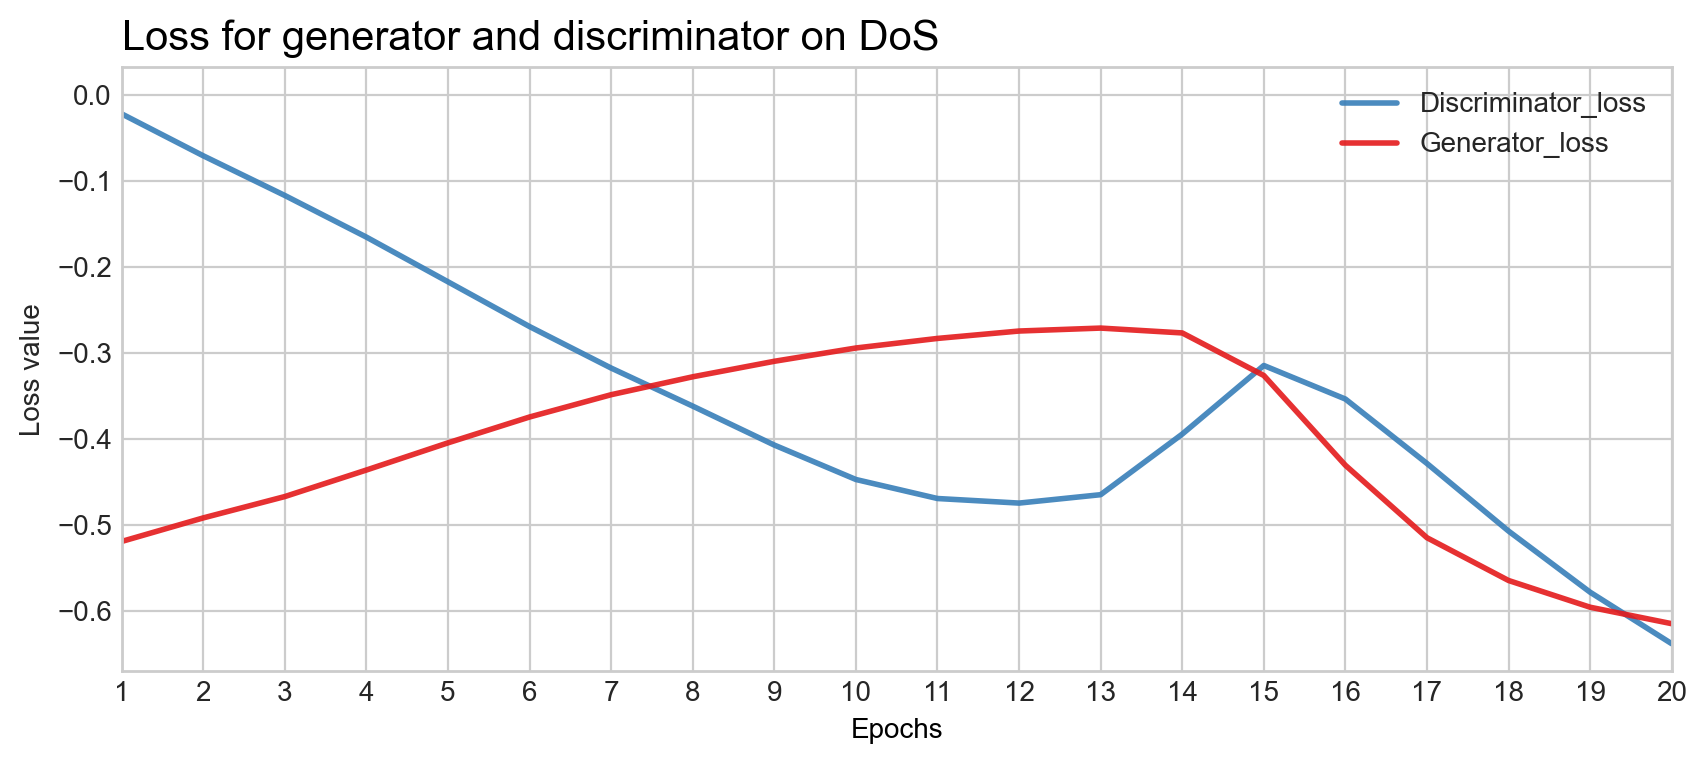

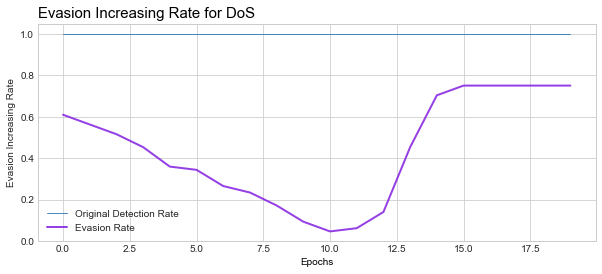

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: CNN
    Amout of DoS:	4344 (67 batchs - 64 records/batch)
	   0 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   1 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   2 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   3 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.07% 	 Evasion Rate : 41.65%  	 Euclidean Distance : 2.14%
	   4 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   5 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   6 epochs:	Origin DR : 99.52% 	 Adversarial DR : 58.12% 	 Evasion Rate : 41.60%  	 Euclidean Distance : 2.14%
	   7 epochs:	Origin DR : 

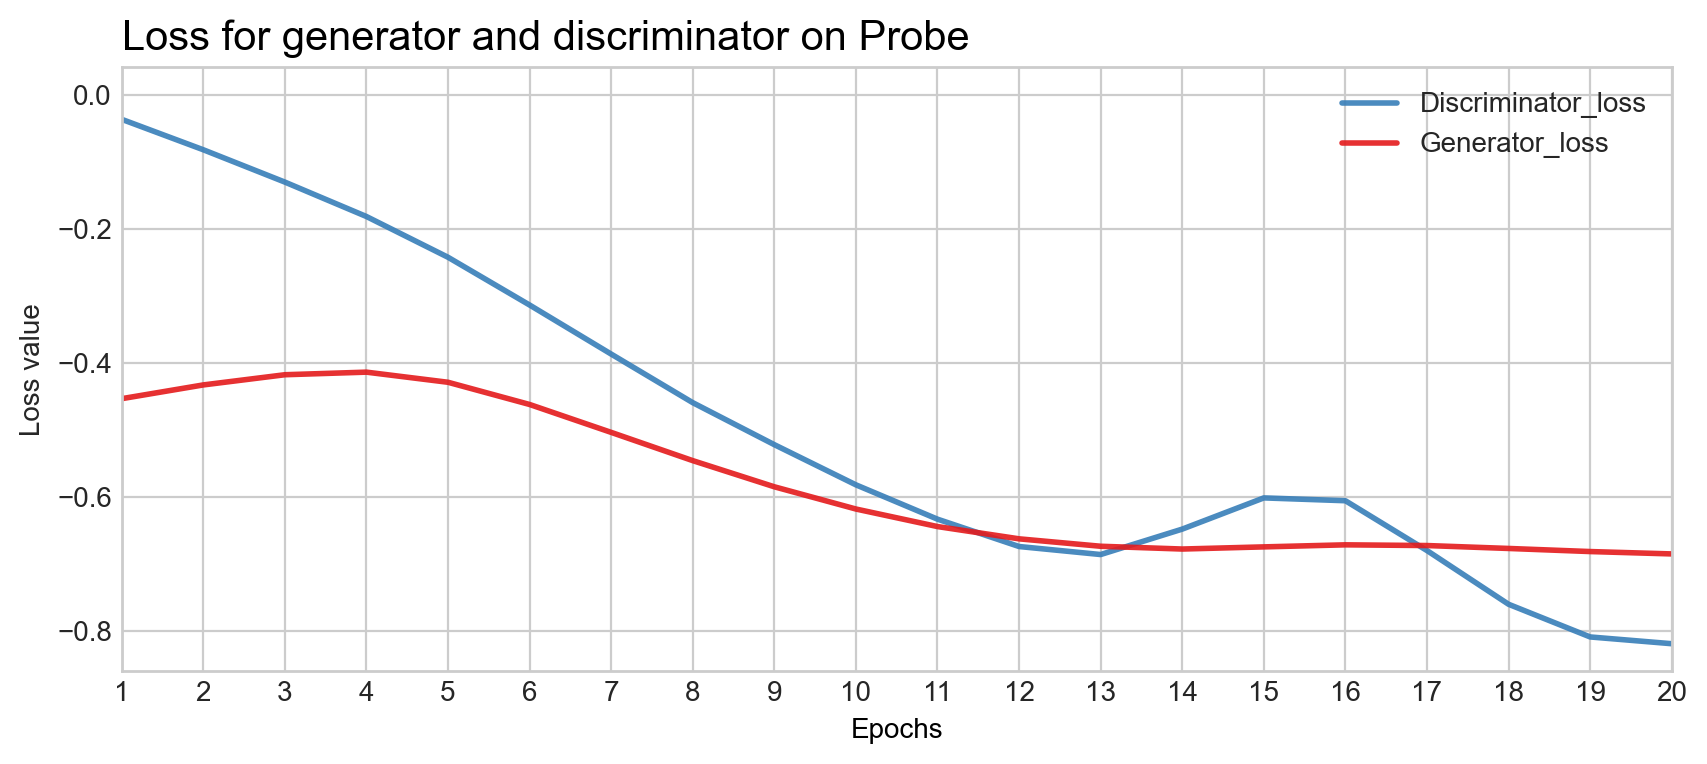

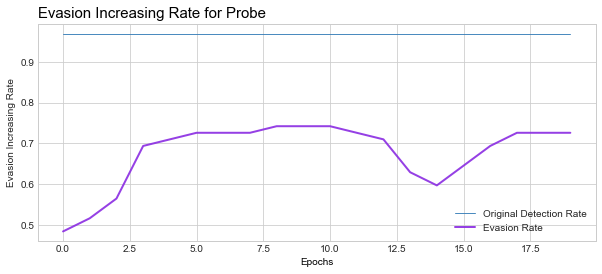

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: CNN
    Amout of Probe:	2402 (37 batchs - 64 records/batch)
	   0 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.66% 	 Evasion Rate : 80.09%  	 Euclidean Distance : 2.76%
	   1 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.75% 	 Evasion Rate : 80.00%  	 Euclidean Distance : 2.76%
	   2 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.75% 	 Evasion Rate : 80.00%  	 Euclidean Distance : 2.76%
	   3 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.70% 	 Evasion Rate : 80.04%  	 Euclidean Distance : 2.76%
	   4 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.75% 	 Evasion Rate : 80.00%  	 Euclidean Distance : 2.76%
	   5 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.75% 	 Evasion Rate : 80.00%  	 Euclidean Distance : 2.76%
	   6 epochs:	Origin DR : 98.74% 	 Adversarial DR : 19.66% 	 Evasion Rate : 80.09%  	 Euclidean Distance : 2.76%
	   7 epochs:	Origin DR 

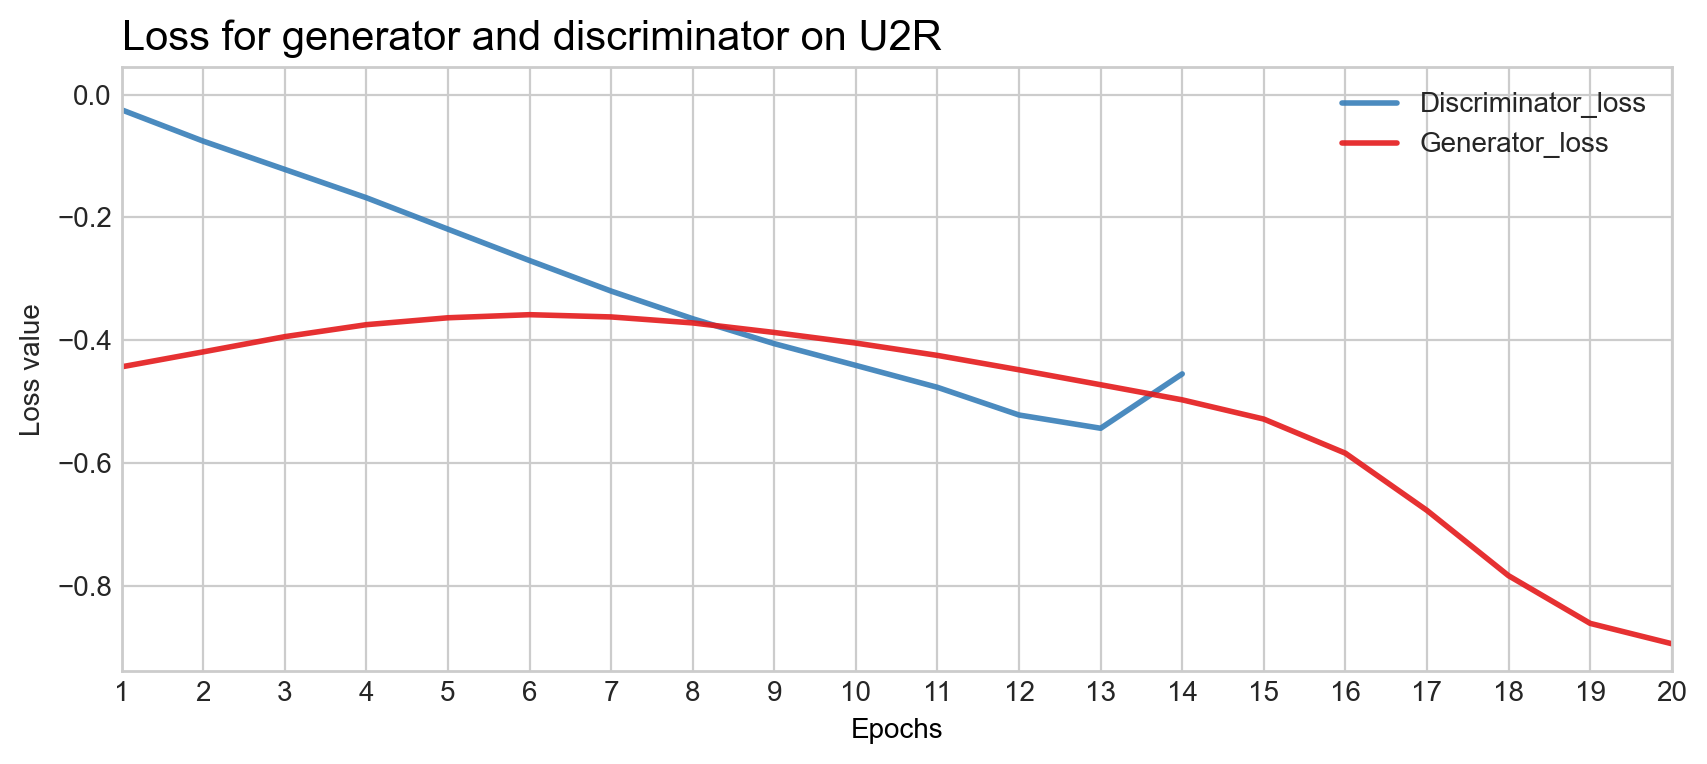

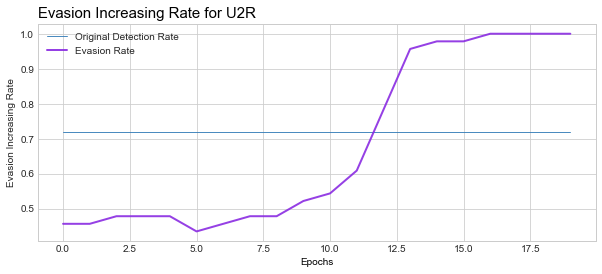

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: CNN
    Amout of U2R:	67 (1 batchs - 64 records/batch)
	   0 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.09% 	 Evasion Rate : 99.88%  	 Euclidean Distance : 1.01%
	   1 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.04% 	 Evasion Rate : 99.94%  	 Euclidean Distance : 1.01%
	   2 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.09% 	 Evasion Rate : 99.88%  	 Euclidean Distance : 1.01%
	   3 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.00% 	 Evasion Rate : 100.00%  	 Euclidean Distance : 1.01%
	   4 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.04% 	 Evasion Rate : 99.94%  	 Euclidean Distance : 1.01%
	   5 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.00% 	 Evasion Rate : 100.00%  	 Euclidean Distance : 1.00%
	   6 epochs:	Origin DR : 71.88% 	 Adversarial DR : 0.00% 	 Evasion Rate : 100.00%  	 Euclidean Distance : 1.01%
	   7 epochs:	Origin DR : 71.88% 

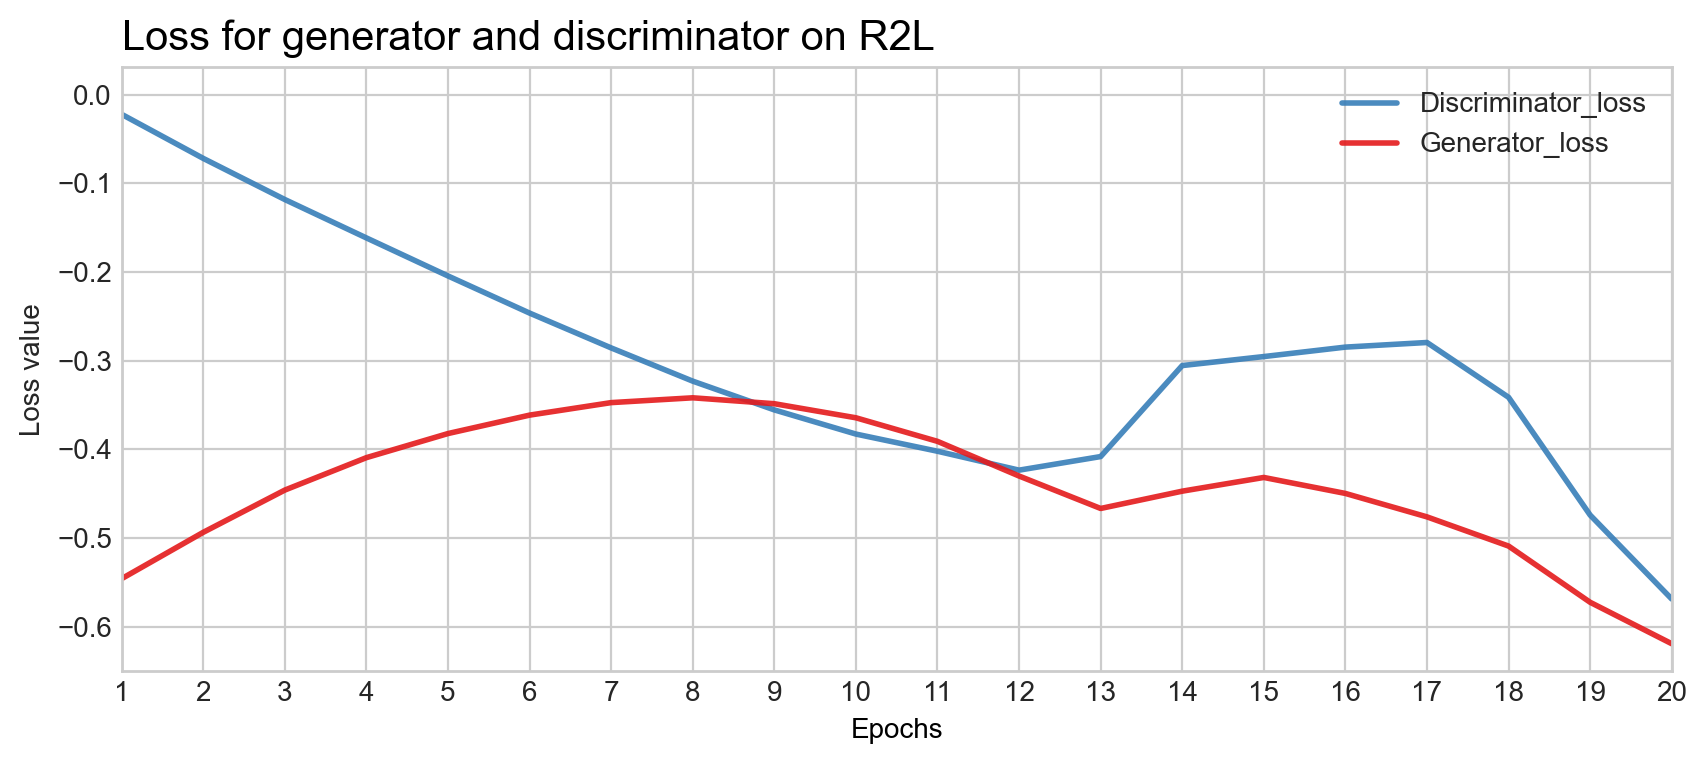

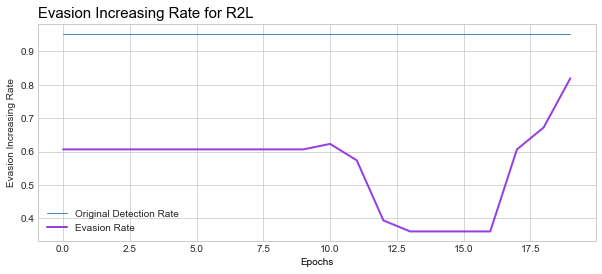

======================================== ADVERSARIAL TRAFFIC EVALUATING ========================================
 IDS Model: CNN
    Amout of R2L:	2707 (42 batchs - 64 records/batch)
	   0 epochs:	Origin DR : 93.06% 	 Adversarial DR : 21.96% 	 Evasion Rate : 76.40%  	 Euclidean Distance : 0.73%
	   1 epochs:	Origin DR : 93.06% 	 Adversarial DR : 21.96% 	 Evasion Rate : 76.40%  	 Euclidean Distance : 0.73%
	   2 epochs:	Origin DR : 93.06% 	 Adversarial DR : 21.96% 	 Evasion Rate : 76.40%  	 Euclidean Distance : 0.73%
	   3 epochs:	Origin DR : 93.06% 	 Adversarial DR : 22.31% 	 Evasion Rate : 76.03%  	 Euclidean Distance : 0.73%
	   4 epochs:	Origin DR : 93.06% 	 Adversarial DR : 21.74% 	 Evasion Rate : 76.63%  	 Euclidean Distance : 0.73%
	   5 epochs:	Origin DR : 93.06% 	 Adversarial DR : 22.18% 	 Evasion Rate : 76.17%  	 Euclidean Distance : 0.73%
	   6 epochs:	Origin DR : 93.06% 	 Adversarial DR : 21.88% 	 Evasion Rate : 76.49%  	 Euclidean Distance : 0.73%
	   7 epochs:	Origin DR : 

In [5]:
import matplotlib.pyplot as plt
import math
import os
from datetime import date
import timeit

print(f"{40*'='} TRAINING GAN {40*'='}")
print(f"{80*'='}\n IDS Model: {'CNN'}")
NOISE_DIM = 9

for attack_category in ATTACK_CATEGORIES:

    print(f"{80*'-'}\n    Attack Category: {attack_category}")
    total_time_start = timeit.default_timer()
    evasion_each = []

    # Init GAN-G model
    G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
    print(f"    nf              : {G_OUTPUT_DIM} (num. of nonfunctional features)")
    NOISE_DIM = G_OUTPUT_DIM
    G_INPUT_DIM = NOISE_DIM
    print(f"    GAN-G NOISE DIM : {NOISE_DIM}")
    print(f"    GAN-G INPUT DIM : {G_INPUT_DIM}")
    print(f"    GAN-G OUTPUT DIM: {G_OUTPUT_DIM}")
    generator = init_generator(attack_category)
    discriminator = Discriminator(D_INPUT_DIM)


    #  generator.summary()
    optimizer_G = tf.keras.optimizers.RMSprop(learning_rate)
    optimizer_D = tf.keras.optimizers.RMSprop(learning_rate)
    # Load Raw Attack Dataset

    raw_attack = preprocess_adversarial_data(g_train_data, attack_category)
    # Create batch of attack traffic
    batch_attack = create_batch2(raw_attack, BATCH_SIZE)
    # Declare Loss, DR List and Train GAN-G, GAN-D
    d_losses,g_losses = [],[]
    o_dr, a_dr, eir = [],[],[]
    # Start Training
    print(f"==>IDSGAN start training")
    print(f"{4*' '}Folder for saving GAN Models : {GAN_Save_Path}")
    labels = ['Epoch', 'G-Loss', 'D-Loss', 'Normal-loss','Benign-loss', 'O-DR(%)', 'A-DR(%)', 'Runtime(s)']
    print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*labels))
    for epoch in range(MAX_EPOCH):
        batch_normal = create_batch2(normal,BATCH_SIZE)
        epoch_time_start = timeit.default_timer()
        cnt = 0
        run_g_loss = []
        run_d_loss = []
        run_loss_normal = []
        run_loss_attack = []
        epoch_o_drs, epoch_a_drs = [], []

        for idx, bn in enumerate(batch_normal):
            batch_time = timeit.default_timer()
            normal_b = tf.convert_to_tensor(bn, dtype = np.float64)
            attack_traffic = tf.convert_to_tensor(batch_attack[idx % len(batch_attack)])

            #  Train Generator

            g_loss = train_generator(generator, discriminator, optimizer_G, NOISE_DIM, attack_traffic, attack_category)
            g_loss = g_loss.numpy()
            run_g_loss.append(g_loss)
            


            # Train Discriminator
            d_loss, loss_normal, loss_attack = train_discriminator(discriminator, ids_model, generator, CRITIC_ITERS, optimizer_D, normal_b, NOISE_DIM, attack_traffic, attack_category)
            run_d_loss.append(d_loss)
            run_loss_normal.append(loss_normal)
            run_loss_attack.append(loss_attack)

            # CALC Epoch DR

            adversarial_attack, generator_out = gen_adversarial_attack(generator, NOISE_DIM, attack_traffic, attack_category)

        gen_loss = np.mean(run_g_loss)
        dis_loss = np.mean(run_d_loss)
        dis_n_loss = np.mean(run_loss_normal)
        dis_a_loss = np.mean(run_loss_attack)
        origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_traffic, adversarial_attack)
        epoch_o_drs.append(origin_dr)
        epoch_a_drs.append(adversarial_dr)
        epoch_o_dr = np.mean(epoch_o_drs)
        epoch_a_dr = np.mean(epoch_a_drs)
        epoch_eir = 1 - (epoch_a_dr/epoch_o_dr)
        o_dr.append(epoch_o_dr)
        a_dr.append(epoch_a_dr)
        eir.append(epoch_eir)
        g_losses.append(gen_loss)
        d_losses.append(dis_loss)
        evasion_each.append(epoch_eir)

        runtime = timeit.default_timer() - batch_time
        print_vals = [(epoch + 1), gen_loss, (dis_loss / CRITIC_ITERS), (dis_n_loss / CRITIC_ITERS), (dis_a_loss / CRITIC_ITERS), (epoch_o_dr*100), (epoch_a_dr*100), runtime]
        print_string = []
        for val in print_vals:
            if isinstance(val, float):
                print_string.append(str(f"{val:.6f}"))
            else:
                print_string.append(str(val))
        print("{: >10} {: >15} {: >15} {: >15} {: >15} {: >15} {: >15} {: >15}".format(*print_string))

        # Save Adversarial Dataset each 10 epoch

    total_runtime = timeit.default_timer() - total_time_start
    print(f"Training Runtime: {total_runtime:.2f}")
    print("IDSGAN finish training!")
    EVASION_RATE[attack_category] = evasion_each
    # Show Graph
    # Loss-Graph
    my_x_ticks = np.arange(1,21,1)
    plt.style.use('seaborn-whitegrid')
    palette = plt.get_cmap('Set1')
    plt.figure(dpi = 200,figsize=(10, 4))
    d_losses.insert(0,0)
    g_losses.insert(0,0)
    plt.plot(d_losses, marker='', color=palette(1), linewidth=2, alpha=0.9, label="Discriminator_loss")
    plt.plot(g_losses, marker='', color=palette(0), linewidth=2, alpha=0.9, label="Generator_loss")
    plt.title(f"Loss for generator and discriminator on {attack_category}", loc='left', fontsize=15, fontweight=5, color='Black')
    plt.xlim((1, 20))
    plt.xticks(my_x_ticks)
    plt.xlabel("Epochs",fontsize=10, fontweight=5, color='Black')
    plt.ylabel("Loss value")
    plt.legend(loc="upper right")
    plt.show()


    plt.style.use('seaborn-whitegrid')
    palette = plt.get_cmap('Set1')
    plt.figure(figsize=(10, 4))
    plt.plot(o_dr, marker='', color=palette(1), linewidth=1, alpha=0.9, label="Original Detection Rate")
    plt.plot(eir, marker='', color='blueviolet', linewidth=2, alpha=0.9, label="Evasion Rate")    

    plt.title(f"Evasion Increasing Rate for {attack_category}", loc='left', fontsize=15, fontweight=5, color='Black')
    plt.xlabel("Epochs",fontsize=10, fontweight=5, color='Black')
    plt.ylabel("Evasion Increasing Rate")      
    plt.legend()
    plt.show()

        # Adversarial Traffic Evaluating
    print(f"{40*'='} ADVERSARIAL TRAFFIC EVALUATING {40*'='}")
    print(f"{80*'='}\n IDS Model: CNN")

    # Load Attack Dataset
    test_raw_attack = preprocess_adversarial_data(testset, attack_category)
    # Create batch of attack traffic
    batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
    n_batch_attack = len(batch_attack)
    print(f"{4*' '}Amout of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")

    # Calc DR through each epoch

    for epoch in range(0, MAX_EPOCH+1):
        # Load GAN-G Model
        o_dr,a_dr,euc =[],[],[]
        generated_dataset = pd.DataFrame(columns=DATASET_COLUMNS)
        euc_dis = pd.DataFrame(columns=DATASET_COLUMNS)
        for idx, bn in enumerate(test_batch_normal):
            normal_b = tf.convert_to_tensor(bn)
            attack_b = tf.convert_to_tensor(batch_attack[idx % n_batch_attack])
            # Generate Adversarial Traffic
            adversarial_attack_b,generator_out = gen_adversarial_attack(generator, NOISE_DIM, attack_b, attack_category)
            if (idx < n_batch_attack):
                epoch_dataset = pd.DataFrame(data = np.array(adversarial_attack_b), columns=DATASET_COLUMNS)
                generated_dataset = pd.concat([generated_dataset,epoch_dataset], ignore_index = True)
                attack_b_arr = np.array(attack_b)

                euc_dis = np.sqrt(np.sum((epoch_dataset - attack_b_arr) ** 2))
                euc_mean = np.mean(euc_dis)
                euc.append(euc_mean)
            # Calc DR
            origin_dr, adversarial_dr = cal_dr(ids_model, normal_b, attack_b, adversarial_attack_b)
            o_dr.append(origin_dr)
            a_dr.append(adversarial_dr)
        eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
        print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t Evasion Rate : {eir*100:.2f}%  \t Euclidean Distance : {np.mean(euc):.2f}%")

        if epoch == MAX_EPOCH:
            generated_dataset_folder_path = str(f"{generated_dataset_path}IDSGAN_CNN_WGAN/{attack_category}/")
            if not os.path.exists(generated_dataset_folder_path):
                os.makedirs(generated_dataset_folder_path)
            generated_dataset_file_path = generated_dataset_folder_path + str(f"CNN_{attack_category}.csv")
            save_generated_dataset(generated_dataset, generated_dataset_file_path)


In [6]:
DoS = EVASION_RATE['DoS']
U2R = EVASION_RATE['U2R']
R2L = EVASION_RATE['R2L']
Probe = EVASION_RATE['Probe']
np.save(SavedModelPath + 'DoS_CNN_IDSGAN_wgan' , DoS)
np.save(SavedModelPath + 'U2R_CNN_IDSGAN_wgan' , U2R)
np.save(SavedModelPath + 'R2L_CNN_IDSGAN_wgan' , R2L)
np.save(SavedModelPath + 'Probe_CNN_IDSGAN_wgan' , Probe)

os.listdir(SavedModelPath)

['U2R_CNN_Feature.npy',
 'U2R_CNN_IDSGAN.npy',
 'Probe_CNN_Feature_wgan.npy',
 'Losses',
 'Probe_CNN.npy',
 'Probe_CNN_IDSGAN_wgan.npy',
 'R2L_CNN_IDSGAN_lsgan.npy',
 'R2L_CNN_Feature_lsgan.npy',
 'DoS_CNN_IDSGAN_wgan.npy',
 'Probe_BILSTM.npy',
 '.DS_Store',
 'Probe_CNN_IDSGAN.npy',
 'R2L_CNN_IDSGAN_wgan.npy',
 'U2R_CNN_IDSGAN_lsgan.npy',
 'U2R_CNN_F.npy',
 'IDSModel',
 'DoS_CNN_Feature_wgan.npy',
 'DoS_CNN_IDSGAN.npy',
 'R2L_CNN_IDSGAN.npy',
 'Probe_CNN_Feature.npy',
 'DoS_CNN_Feature_lsgan.npy',
 'DoS_CNN_F.npy',
 'R2L_BILSTM.npy',
 'U2R_BILSTM_F.npy',
 'GANModel',
 'U2R_BILSTM.npy',
 'U2R_CNN_IDSGAN_wgan.npy',
 'DoS_BILSTM.npy',
 'Probe_CNN_F.npy',
 'DoS_CNN_IDSGAN_lsgan.npy',
 'U2R_CNN_Feature_lsgan.npy',
 'R2L_BILSTM_F.npy',
 'U2R_CNN_Feature_wgan.npy',
 'DoS_CNN.npy',
 'DoS_BILSTM_F.npy',
 'R2L_CNN_Feature.npy',
 'Probe_CNN_Feature_lsgan.npy',
 'R2L_CNN.npy',
 'R2L_CNN_Feature_wgan.npy',
 'Probe_BILSTM_F.npy',
 'U2R_CNN.npy',
 'R2L_CNN_F.npy',
 'Probe_CNN_IDSGAN_lsgan.npy',
 'DoS

In [7]:

ATTACK_CATEGORIES = ['DoS','Probe','U2R','R2L']
for attack_category in ATTACK_CATEGORIES:
    raw = df[df["Class"] == attack_category]
    del raw["Class"]
    generated_arr_path = str(f"{generated_dataset_path}IDSGAN_CNN/{attack_category}/") + str(f"CNN_{attack_category}.csv")
    generated_arr = pd.read_csv(generated_arr_path)
    pred_label = (bi_ids.predict(generated_arr) > 0.5).astype("int8").flatten()
    cnt = 0
    for i in pred_label:
        if i == 1:
            cnt += 1
    raw = df[df["Class"] == attack_category]
    del raw["Class"]
    raw_pred_label = (bi_ids.predict(raw) > 0.5).astype("int8").flatten()
    cnt_raw = 0
    for i in raw_pred_label:
        if i == 1:
            cnt_raw += 1
    o_dr = cnt_raw/len(raw)
    a_dr = cnt/len(generated_arr)
    eir = 1 - a_dr/o_dr
    
    print(eir)
    
    

NameError: name 'bi_ids' is not defined